In [1]:
import os, sys

os.chdir('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
sys.path.append('e:\Downloads (E)\@Books\@TPM\@PDPC\@data_analysis\model_build')
# ^ just a sanity thing: console starts from project root, but pycharm 'run in console' runs with 'model_build' as working directory

import OFM_model as ofm
import OFM_sensitivity as ofms
import pandas as pd
import numpy as np
import math
from tqdm import tqdm  # for progress bars
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
# from matplotlib.colors import TwoSlopeNorm
import cmasher as cmr
import colorcet as cet
from importlib import reload  ## for reloading packages
import OFM_postprocess_scripts as post
import OFM_sensitivity_postprocess as post_sa
import scipy
import pickle
import SALib as salib
import plotly.express as px  # interactive graphing library

In [2]:
model_vers = 'v6b'
sa_exp = post.read_experiments_from_pickle(f'data_output/model{model_vers}_SAexp.pickleobject')

In [3]:
# want to get values of
# extract values from problem attribute
p = sa_exp.problem
# merge inputs from scenarios attribute?
# match outputs from names index
sa_preplot_rename = {
    'u_Rzero': r'$R_e$',
    'p_FlightBans': 'Flight Ban Day',
    'u_ImportsIndirect': 'Leakage Rate',
    'u_ImportsFlights': 'Importation Scaling',
    'u_Func_Infectious': "Infectivity Function",
}
infectivity_func_order = ['wild', 'alpha', 'delta', 'omicron', 'omi_high1', 'omi_high2',
                          'omi_high3']  # append order of 'severity' for infectivity function
infectivity_func_order = dict((name, enum) for enum, name in enumerate(infectivity_func_order))

outputs = pd.DataFrame.from_dict(sa_exp.scenarios, orient='index').rename(columns=sa_preplot_rename)
outputs['Infectivity Function'] = pd.DataFrame(outputs['Infectivity Function'].tolist())[0]#.map(infectivity_func_order)  # was a tuple of name and infectivity function itself, we only need the former

outputs = outputs.join(pd.DataFrame(p.results, columns=p['outputs']))
outputs['Flight Ban Day'] = outputs['Flight Ban Day'] - sa_exp.c_nominal_ref_date

In [4]:
# need to segment the days_10k_cumulative to high, low and mid variants...
# how about a violin plot?


<Axes: xlabel='days_10k_cumulative', ylabel='Density'>

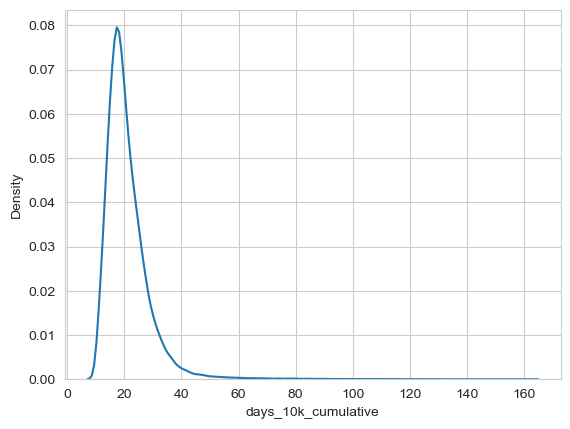

In [5]:
# get distribution of all cumulative days
sns.kdeplot(outputs, x='days_10k_cumulative')

In [6]:
# find the number to cut for quartiles
np.percentile(outputs.days_10k_cumulative, q=[25, 50, 75, 100])

array([ 16.,  19.,  24., 162.])

In [7]:
# scipy.stats.mode(outputs.days_10k_cumulative)
outputs.days_10k_cumulative.min()

10.0

In [8]:
# Cut the outputs per quartile, with categorical labels
labels = ['1 (10-16)', '2 (16-19)', '3 (19-24)','4 (24-162)']
bins = [10, 16, 19, 24, 162]
sorted_name = 'Quartile\n(Days to 10k\ncumulative cases)'
outputs[sorted_name] = pd.cut(outputs.days_10k_cumulative, bins=bins, include_lowest=True, labels=labels)

In [9]:
# sns.violinplot(outputs, y='R_e', hue=sorted_name, bw_adjust=2, cut=0, density_norm='count', gap=0.1)

In [10]:
outputs2 = outputs.melt(id_vars=['days_10k_cumulative', sorted_name],
                        value_vars=sa_preplot_rename.values())


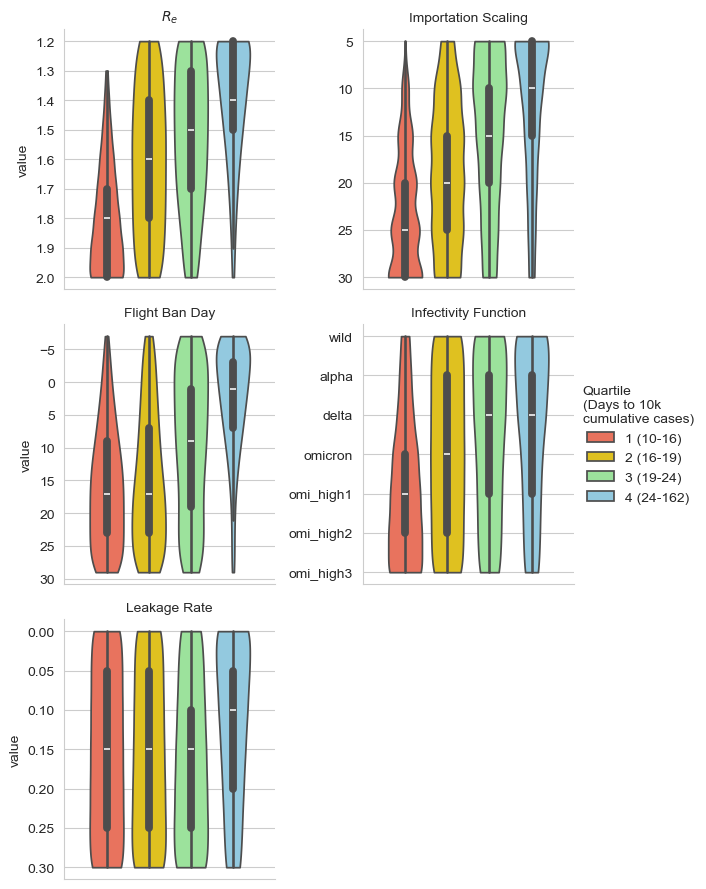

In [11]:
# put everything together as a catplot
# todo
# rename subtitles
# make nicer axes for eg. flight ban day?
# Reverse infectivity function scaling?
# use more intuitive colouring
col_order = [r'$R_e$','Importation Scaling', 'Flight Ban Day', 'Infectivity Function', 'Leakage Rate']
palette = dict(zip(labels,['tomato','gold','lightgreen','skyblue']))
fig = sns.catplot(data=outputs2, kind='violin', col='variable', y='value', hue=sorted_name,
                  col_order=col_order,palette=palette,
                  bw_adjust=2, cut=0, native_scale=True, gap=0.2, col_wrap=2, sharey=False,
                  height=3, aspect=1)
fig.set_titles('{col_name}')
fig.set_xlabels('') # turn off x-labels
fig.savefig(f'output_figures/{model_vers}/SA-{sa_exp.problem.results.shape[0]}_tornado_plot.jpg', dpi=300)